<div style="text-align:center;">
    <img src="misc/ktub.svg" alt="KTU Logo" style="width:200px;"/>
    <h3>Kaunas University of Technology</h3>
    <h4>Faculty of Informatics</h4>
    <h2>First laboratory work: KNN, DT, and RF</h2>
    <h4>P170M109 Computational Intelligence and Decision Making</h4>
</div>
<div style="text-align:right;">
<p>Gintautas Šedys</p>
<p>Student</p>
</br>
<p>doc. Andrius Kriščiūnas</p>
<p>Professor</p>
</div>
<div style="text-align:center;">
<h3>Kaunas 2022</h3>
</div>

----

### Task

Problem: based on the given data of historical real estate transactions create the decision-making model (DMM) which aims to predict prices of new real estate objects.

Project workflow:
* P1. Perform given data analysis and preprocessing
* P2. Implement K-Nearest Neighbors (KNN), Decision tree (DT), and random forest (RF) algorithms (You cannot use library functions for these algorithms)
* P3. Use implemented algorithms to create DMM for the given problem and evaluate the results.
* P4. Use “scikit-learn” (or other) library functions for the same algorithms and evaluate the results.
* P5. Write conclusions.

Data:
* historicalData.tsv – data to create the DMMs.
* newData.tsv – assume, that you don’t have this data. We use this data only to evaluate (during work defense) how DMM model works with unseen data.


### Workflow requirements in detail

P1. Data analysis and preprocessing
* determine data types of features.
* provide data quality report for all features (analyze categorical and continuous features separately). The form of the report is given in slides (Input Analysis).
* provide distribution characteristics (histogram, frequency table, bar plot, box plot, pie chart …) based on the data type for each feature. For numerical features, explore the shape of distribution, perform standardization or normalization. Consider the normality of data.
* comment whether it is possible to include derived features (ratios, flags, mapping, etc.) and append Analytics Base Table (ABT) if needed. 
* perform data preprocessing actions if You think it is necessary

P2. Implementation of KNN, DT, and RF
* Requirements for algorithms (parameters to change)
    * KNN – k value
    * DT – minSamplesLeaf; maxDepth.
    * RF – nEstimators;
* Implementation can be based on lectures or online materials, but references to the original source (if used) are necessary. Student must be able to comment any line (even if it is used from examples or other materials).

P3 and P4.
* Creating DMM means to select optimal hyper-parameters and perform output analysis.
* Evaluate results using MAE, MAPE metrics.
* Scikit-learn library models:
    * https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    * https://scikit-learn.org/stable/modules/tree.html
    * https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

P5. Work conclusions
* compare the results of DMMs that use Your implementation and “scikit-learn” library.

Original data set available at: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

----

### P1. Data analysis and preprocessing

* determine data types of features.
* provide data quality report for all features (analyze categorical and continuous features separately). The form of the report is given in slides (Input Analysis).
* provide distribution characteristics (histogram, frequency table, bar plot, box plot, pie chart …) based on the data type for each feature. For numerical features, explore the shape of distribution, perform standardization or normalization. Consider the normality of data.
* comment whether it is possible to include derived features (ratios, flags, mapping, etc.) and append Analytics Base Table (ABT) if needed. 
* perform data preprocessing actions if You think it is necessary

----

In [2]:
# Lib imports

import csv
import pandas
import matplotlib.pyplot as plt
import random
import numpy

In [10]:
# Read data
df = pandas.read_csv("../data/historicalData.tsv", sep='\t', index_col = "Id")
display(df)

,LotFrontage,LotArea,Street,Neighborhood,YearBuilt,YearRemodAdd,CentralAir,PavedDrive,SaleCondition,SalePrice
Id,,,,,,,,,,
1,65.0,8450,Pave,CollgCr,2003,2003,Y,Y,Normal,208500
2,80.0,9600,Pave,Veenker,1976,1976,Y,Y,Normal,181500
3,68.0,11250,Pave,CollgCr,2001,2002,Y,Y,Normal,223500
4,60.0,9550,Pave,Crawfor,1915,1970,Y,Y,Abnorml,140000
5,84.0,14260,Pave,NoRidge,2000,2000,Y,Y,Normal,250000
...,...,...,...,...,...,...,...,...,...,...
995,96.0,12456,Pave,NridgHt,2006,2007,Y,Y,Normal,337500
996,51.0,4712,Pave,BrkSide,1946,1950,Y,Y,Abnorml,121600
997,NaN,10659,Pave,NAmes,1961,1961,Y,Y,Normal,136500


From the data, we see that there are 10 columns in totoal,\
5 of them are numeric and 5 categorical.
* Numeric
    * LotFrontage
    * LotArea
    * YearBuilt
    * YearRemodAdd
    * SalePrice
* categorical_cols
    * Street
    * Neighborhood
    * CentralAir
    * PavedDrive
    * SaleCondition

In [11]:
numeric_cols = ["LotFrontage", "LotArea", "YearBuilt", "YearRemodAdd", "SalePrice"]
categorical_cols = ["Street", "Neighborhood", "CentralAir", "PavedDrive", "SaleCondition"]

Now lets produce some data quality reports\
To do that we first define two functions, one for computing the report of a numeric column, another for categorical

In [109]:
def numeric_report(col, ax = None):
    if ax is not None:
        ax.hist(col, bins = 100)
        ax.set_title(col.name)
    count = len(col)
    missing = col.isna().sum()
    cardinality = len(col.unique())
    res = {
        "name": col.name,
        "count": count,
        "missing": round(missing / count * 100, 2),
        "cardinality": cardinality,
        "min": min(col),
        "q1": col.quantile(0.25),
        "median": col.quantile(0.5),
        "q3": col.quantile(0.75),
        "max": max(col),
        "mean": round(col.mean(), 2),
        "std": round(col.std(), 2)
    }
    return(res)

def categorical_report(col, ax = None):
    count = len(col)
    missing = col.isna().sum()
    cardinality = len(col.unique())

    value_counts = col.value_counts()
    my_mode = value_counts.index.tolist()[0]
    my_mode_c = value_counts.iloc[0]
    my_mode_f = round(my_mode_c / count * 100, 2)
    my_mode2 = value_counts.index.tolist()[1]
    my_mode_c2 = value_counts.iloc[1]
    my_mode_f2 = round(my_mode_c2 / count * 100, 2)

    if ax is not None:
        ax.pie(value_counts, labels = value_counts.index)
        ax.set_title(col.name)

    values = "|".join(str(col.unique().tolist()))
    
    res = {
        "name": col.name,
        "count": count,
        "missing": round(missing / count * 100, 2),
        "cardinality": cardinality,
        "mode": my_mode,
        "mode f.": my_mode_c,
        "mode %": my_mode_f,
        "2nd mode": my_mode2,
        "2nd mode f.": my_mode_c2,
        "2nd mode %": my_mode_f2,
        "values": values,

    }
    return(res)

,count,missing,cardinality,min,q1,median,q3,max,mean,std
name,,,,,,,,,,
LotFrontage,999,17.32,103,21.0,60.0,70.0,80.0,313.0,69.96,23.22
LotArea,999,0.00,780,1300.0,7589.0,9452.0,11632.0,215245.0,10695.11,11417.71
YearBuilt,999,0.00,107,1880.0,1954.0,1974.0,2000.0,2010.0,1971.60,30.00
YearRemodAdd,999,0.00,61,1950.0,1967.0,1994.0,2004.0,2010.0,1985.26,20.41
SalePrice,999,0.00,536,34900.0,130000.0,163990.0,215000.0,755000.0,182260.71,80327.92


,count,missing,cardinality,mode,mode f.,mode %,2nd mode,2nd mode f.,2nd mode %,values
name,,,,,,,,,,
Street,999,0.0,2,Pave,995,99.60,Grvl,4,0.40,"[|'|P|a|v|e|'|,| |'|G|r|v|l|'|]"
Neighborhood,999,0.0,25,NAmes,152,15.22,CollgCr,100,10.01,"[|'|C|o|l|l|g|C|r|'|,| |'|V|e|e|n|k|e|r|'|,| |..."
CentralAir,999,0.0,2,Y,931,93.19,N,68,6.81,"[|'|Y|'|,| |'|N|'|]"
PavedDrive,999,0.0,3,Y,917,91.79,N,61,6.11,"[|'|Y|'|,| |'|N|'|,| |'|P|'|]"
SaleCondition,999,0.0,6,Normal,812,81.28,Partial,91,9.11,"[|'|N|o|r|m|a|l|'|,| |'|A|b|n|o|r|m|l|'|,| |'|..."


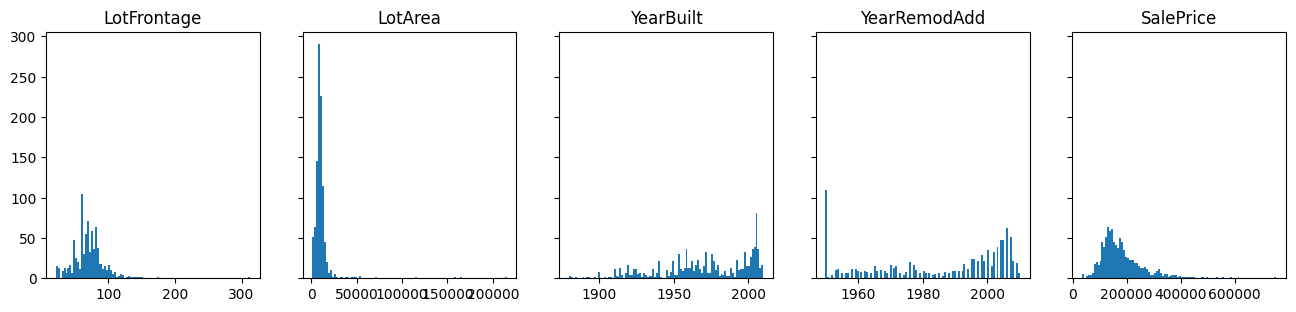

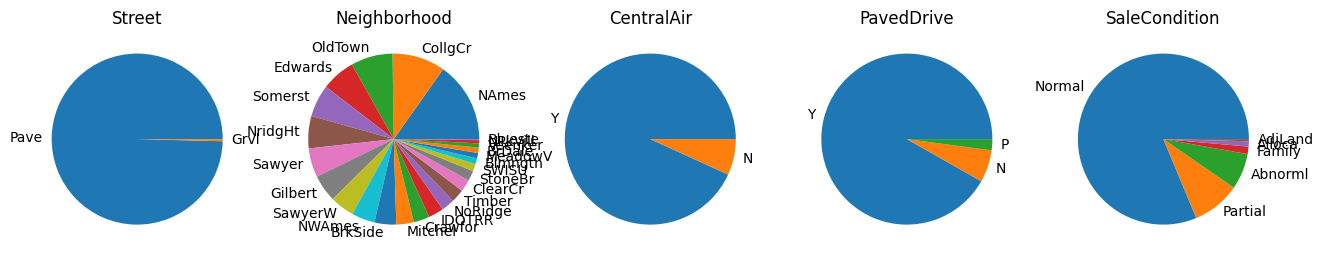

In [110]:
fig, axs = plt.subplots(1, len(numeric_cols), sharey=True, figsize=(16, 16 / len(numeric_cols)))
n_repo = pandas.DataFrame([numeric_report(df[numeric_cols[i]], axs[i]) for i in range(len(numeric_cols))])
n_repo = n_repo.set_index("name")
display(n_repo)
qqq = plt.plot()

fig, axs = plt.subplots(1, len(categorical_cols), sharey=True, figsize=(16, 16 / len(categorical_cols)))
c_repo = pandas.DataFrame([categorical_report(df[categorical_cols[i]], axs[i]) for i in range(len(categorical_cols))])
c_repo = c_repo.set_index("name")
display(c_repo)
qqq = plt.plot()

### About numeric data

From the histograms we can clearly see that there are some outliers in the data (e.g. LotArea).\
We will remove these outliers by limiting our data to not be deviated by more than 3 std from the mean.

### About categorical data

From pie plots and data quality report we can see that:
* Column "Street" is almost irrelevant (99% of streets are paved)
* Column "Neighborhood" could be useful, but it would introduce 25 new futures to our model. With only 999 (before discarding outliers) rows, i don't think it's feasible to use this column. But lets check its corelation with price just for fun.
    * Also this column is very  specifcic to training data, our test data could be forom other city, and thus its neigbhorhoods would be complytly usless to us
* Column "CentralAir" seams great.
* Column "PAvedDrive" seems also great, but it includes value P, i think it should mean "Paved", but we will discard it.
* Column "Sales Condition" also is great, but it has cardinality of 6. We can modify it to only have to values: Normal and Others

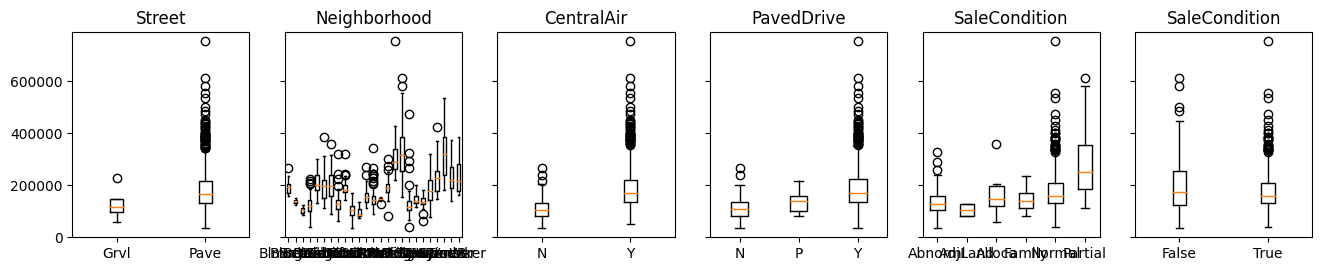

In [100]:
def set_box_plot(data, ax):
    data_ = data.groupby(data.columns[0])["SalePrice"].apply(list)
    ax.boxplot(data_, labels = data_.index)
    ax.set_title(data.columns[0])


fig, axs = plt.subplots(1, len(categorical_cols) + 1, sharey=True, figsize=(16, 16 / (len(categorical_cols) + 1)))
for i in range(len(categorical_cols)):
    set_box_plot(df[[categorical_cols[i], "SalePrice"]], axs[i])
tmp = df[["SaleCondition", "SalePrice"]].copy()
tmp["SaleCondition"] = tmp["SaleCondition"] == "Normal"
set_box_plot(tmp, axs[len(categorical_cols)])
qqq = plt.plot()

After looking at box plots, we can notice that only columns "CentralAir" and "PavedDrive" have noticeable corelation with price. The assumption about "IsNormal was wrong.

----

### Data cleaning

Lets remove outliers by limiting our data to not be deviated by more than 2 std from the mean.
And lets drop all categorical values except from "CentralAir" and "PavedDrive" cols, becouse all of them conist mostly of indetical valeus (90%+)

In [101]:
def filter_numeric(v, std_n):
    n = len(v)
    bv = [True] * n
    def reduce(v, n):
        tmp = v[bv]
        std = tmp.std()
        mean = tmp.mean()
        minstd = mean - std * std_n
        maxstd = mean + std * std_n
        res = (minstd <= v) & (v <= maxstd)
        if(sum(res) == n): return(res)
        return(reduce(v, sum(res)))
    return(reduce(v, n))

my_filter = [True] * df.shape[0]
for i in numeric_cols:
    my_filter = my_filter & filter_numeric(df[i], 2)
my_filter = my_filter & (df["PavedDrive"] != "P")

df_f = df[numeric_cols + ["CentralAir", "PavedDrive"]][my_filter]
display(df_f.shape)

(695, 7)

Lets rerun our analysis with cleaned data.

,count,missing,cardinality,min,q1,median,q3,max,mean,std
name,,,,,,,,,,
LotFrontage,695,0.0,81,24.0,59.0,69.0,80.0,116.0,67.87,17.38
LotArea,695,0.0,539,1300.0,7313.5,9060.0,10800.0,26178.0,9244.21,3249.42
YearBuilt,695,0.0,93,1912.0,1954.0,1974.0,2002.0,2009.0,1972.81,28.55
YearRemodAdd,695,0.0,61,1950.0,1965.0,1995.0,2004.0,2010.0,1985.01,20.98
SalePrice,695,0.0,417,34900.0,129250.0,159000.0,207500.0,342643.0,172302.57,61576.81


,count,missing,cardinality,mode,mode f.,mode %,2nd mode,2nd mode f.,2nd mode %,values
name,,,,,,,,,,
CentralAir,695,0.0,2,Y,646,92.95,N,49,7.05,Y|N
PavedDrive,695,0.0,2,Y,650,93.53,N,45,6.47,Y|N


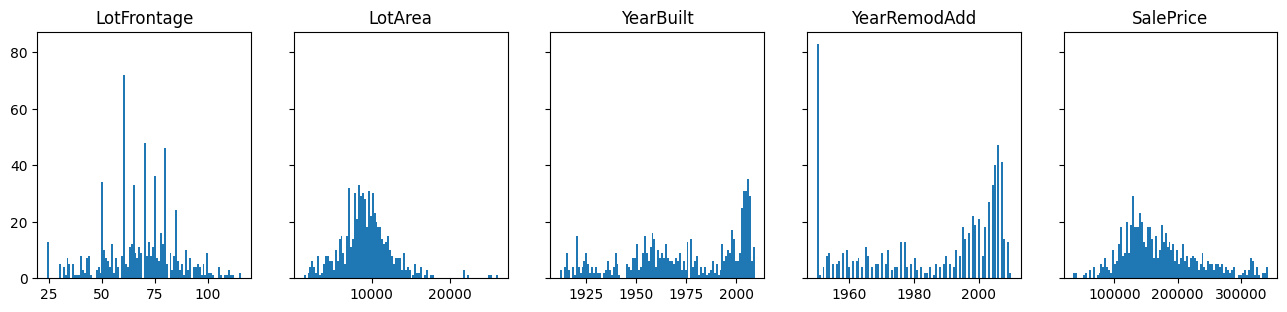

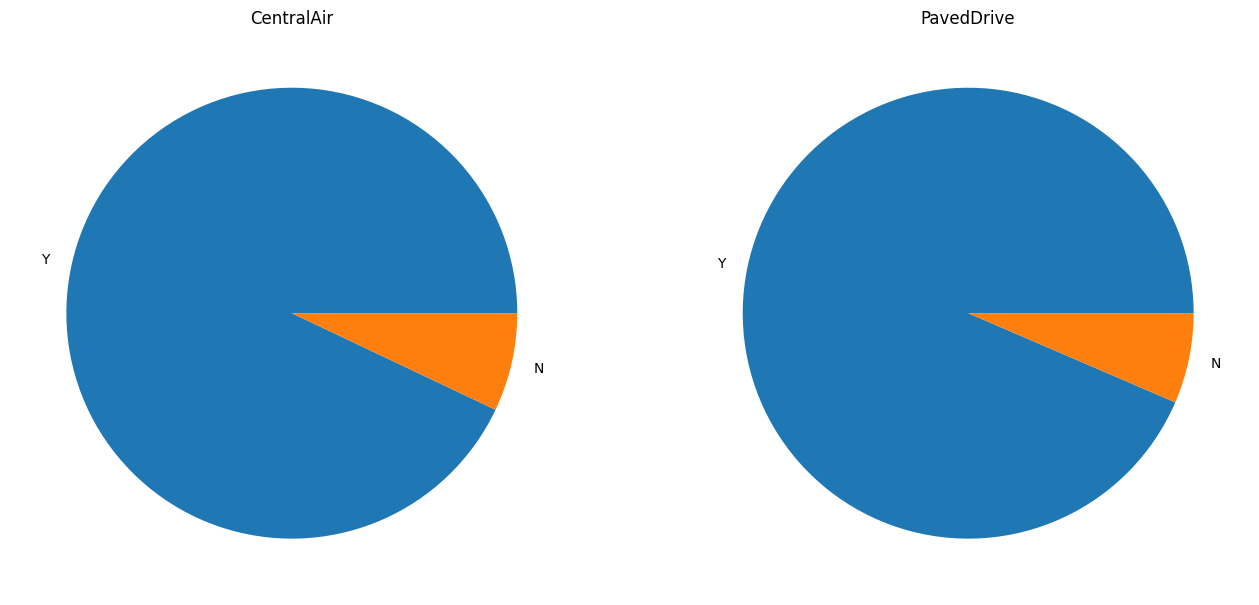

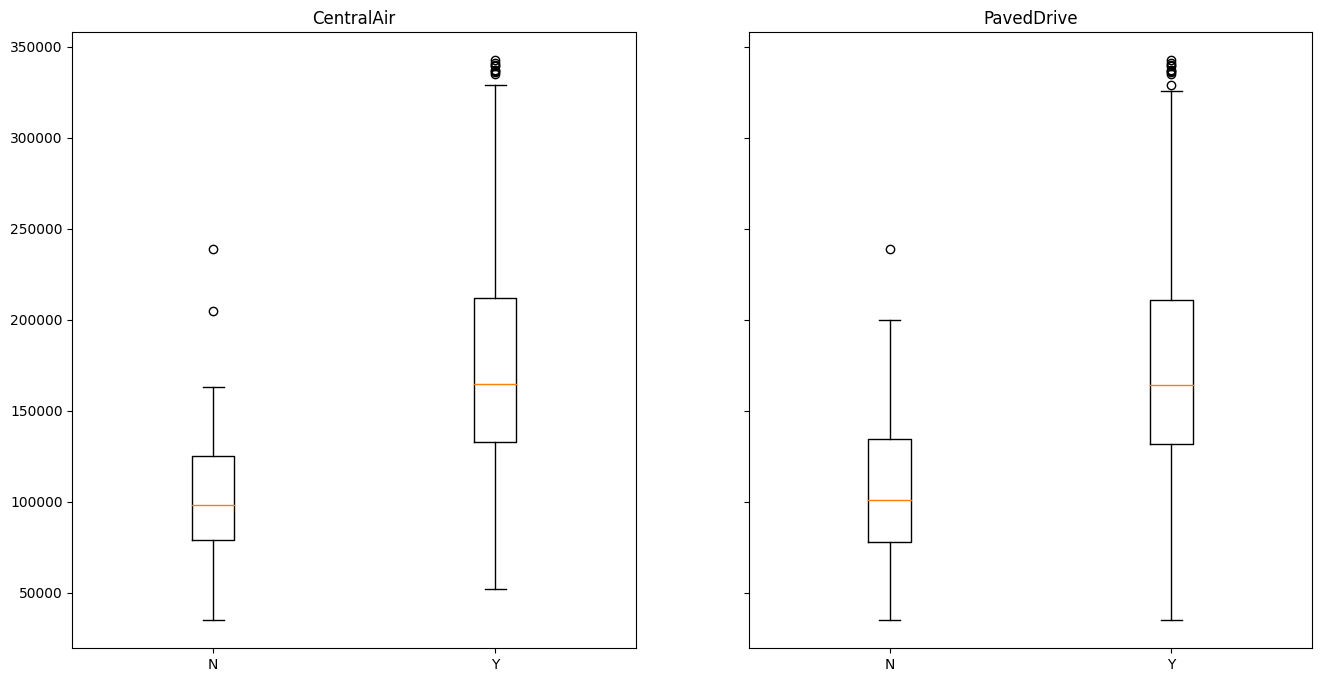

In [102]:
numeric_cols_f = numeric_cols
categorical_cols_f = ["CentralAir", "PavedDrive"]

fig, axs = plt.subplots(1, len(numeric_cols_f), sharey=True, figsize=(16, 16 / len(numeric_cols_f)))
n_repo = pandas.DataFrame([numeric_report(df_f[numeric_cols_f[i]], axs[i]) for i in range(len(numeric_cols_f))])
n_repo = n_repo.set_index("name")
display(n_repo)
qqq = plt.plot()

fig, axs = plt.subplots(1, len(categorical_cols_f), sharey=True, figsize=(16, 16 / len(categorical_cols_f)))
c_repo = pandas.DataFrame([categorical_report(df_f[categorical_cols_f[i]], axs[i]) for i in range(len(categorical_cols_f))])
c_repo = c_repo.set_index("name")
display(c_repo)
qqq = plt.plot()

fig, axs = plt.subplots(1, len(categorical_cols_f), sharey=True, figsize=(16, 16 / len(categorical_cols_f)))
for i in range(len(categorical_cols_f)):
    set_box_plot(df_f[[categorical_cols_f[i], "SalePrice"]], axs[i])
qqq = plt.plot()

After rerunning:
* Histograms shows more "Normal" distribution
* Box plot, conclusions didn't change but we can see, the results a bit more clearly
* std of 2 was selected, because it still gives us 695 rows (999-695=304)
    * std of 3: 999 - 779 = 220
    * std of 4: 999 - 797 = 202

After cleaning our data, lets normalize it, and drop unnecessary columns.

It's also possible to add additional feature, frontage to area ratio

In [103]:
df_f["area_frontage"] = df_f["LotArea"] / df_f["LotFrontage"]
numeric_cols_f = numeric_cols_f + ["area_frontage"]

In [104]:
def get_stand_args(df):
    res = pandas.DataFrame([{"name": df[col].name, "std": df[col].std(), "mean": df[col].mean()} for col in df.columns[df.dtypes != "object"]])
    res = res.set_index("name")
    return(res)

def stand_df(df, args):
    df = df.copy()
    for i in args.index:
        df[i] = (df[i] - args.loc[i, "mean"]) / args.loc[i, "std"]
    for i in df.columns[df.dtypes == "object"]:
        df[i] = [1 if j == "Y" else -1 for j in df[i]]
    return(df)

def de_stand_df(df, args):
    df = df.copy()
    for i in args.index:
        df[i] = (df[i] * args.loc[i, "std"]) + args.loc[i, "mean"]
    return(df)

def get_norm_args(df):
    res = pandas.DataFrame([{"name": df[col].name, "max": df[col].max(), "min": df[col].min()} for col in df.columns[df.dtypes != "object"]])
    res = res.set_index("name")
    return(res)

def norm_df(df, args):
    df = df.copy()
    for i in args.index:
        df[i] = (df[i] - args.loc[i, "min"]) / (args.loc[i, "max"] - args.loc[i, "min"])
    for i in df.columns[df.dtypes == "object"]:
        df[i] = [1 if j == "Y" else -1 for j in df[i]]
    return(df)

def de_norm_df(df, args):
    df = df.copy()
    for i in args.index:
        df[i] = (df[i] * (args.loc[i, "max"] - args.loc[i, "min"])) + args.loc[i, "min"]
    return(df)

In [105]:
args_f_s = get_stand_args(df_f)
df_f_s = stand_df(df_f, args_f_s)
display(df_f_s)

args_f_n = get_norm_args(df_f)
df_f_n = norm_df(df_f, args_f_n)
display(df_f_n)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,SalePrice,CentralAir,PavedDrive,area_frontage
Id,,,,,,,,
1,-0.165048,-0.244415,1.057658,0.857534,0.587842,1,1,-0.163471
2,0.697855,0.109495,0.111889,-0.429384,0.149365,1,1,-0.370347
3,0.007532,0.617278,0.987601,0.809870,0.831440,1,1,0.569722
4,-0.452683,0.094107,-2.024846,-0.715366,-0.524590,1,1,0.439917
5,0.927963,1.543597,0.952572,0.714543,1.261797,1,1,0.659107
...,...,...,...,...,...,...,...,...
990,-0.165048,-0.344433,1.162743,1.000524,0.401083,1,1,-0.266909
993,0.697855,0.158734,-0.308452,0.380897,0.238684,1,1,-0.328972
994,0.007532,-0.122547,1.127714,1.000524,0.025942,1,1,-0.161646


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,SalePrice,CentralAir,PavedDrive,area_frontage
Id,,,,,,,,
1,0.445652,0.287403,0.938144,0.883333,0.564107,1,1,0.139546
2,0.608696,0.333628,0.659794,0.433333,0.476372,1,1,0.122103
3,0.478261,0.399952,0.917526,0.866667,0.612849,1,1,0.201368
4,0.391304,0.331618,0.030928,0.333333,0.341519,1,1,0.190423
5,0.652174,0.520942,0.907216,0.833333,0.698960,1,1,0.208904
...,...,...,...,...,...,...,...,...
990,0.445652,0.274339,0.969072,0.933333,0.526738,1,1,0.130825
993,0.608696,0.340059,0.536082,0.716667,0.494244,1,1,0.125592
994,0.478261,0.303320,0.958763,0.933333,0.451676,1,1,0.139700


Lets rerun our analysis with standaritzed data. The data quality report should be easier to understand now

Also lets produce scatter matrix

,count,missing,cardinality,min,q1,median,q3,max,mean,std
name,,,,,,,,,,
LotFrontage,695,0.0,81,-2.523652,-0.510210,0.065059,0.697855,2.768824,0.0,1.0
LotArea,695,0.0,539,-2.444808,-0.594169,-0.056689,0.478791,5.211329,-0.0,1.0
YearBuilt,695,0.0,93,-2.129931,-0.658736,0.041833,1.022629,1.267828,-0.0,1.0
YearRemodAdd,695,0.0,61,-1.668638,-0.953684,0.476225,0.905197,1.191179,0.0,1.0
SalePrice,695,0.0,417,-2.231401,-0.699169,-0.216032,0.571602,2.766308,-0.0,1.0
area_frontage,695,0.0,474,-1.818479,-0.441593,-0.183714,0.188724,10.041426,-0.0,1.0


,count,missing,cardinality,mode,mode f.,mode %,2nd mode,2nd mode f.,2nd mode %,values
name,,,,,,,,,,
CentralAir,695,0.0,2,1,646,92.95,-1,49,7.05,"[|1|,| |-|1|]"
PavedDrive,695,0.0,2,1,650,93.53,-1,45,6.47,"[|1|,| |-|1|]"


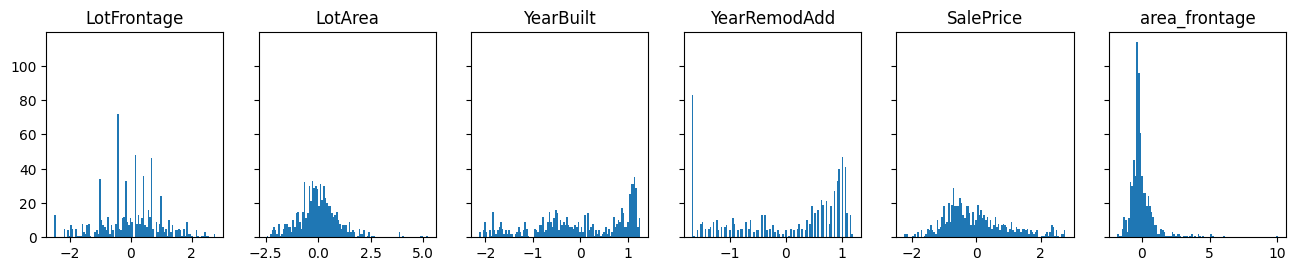

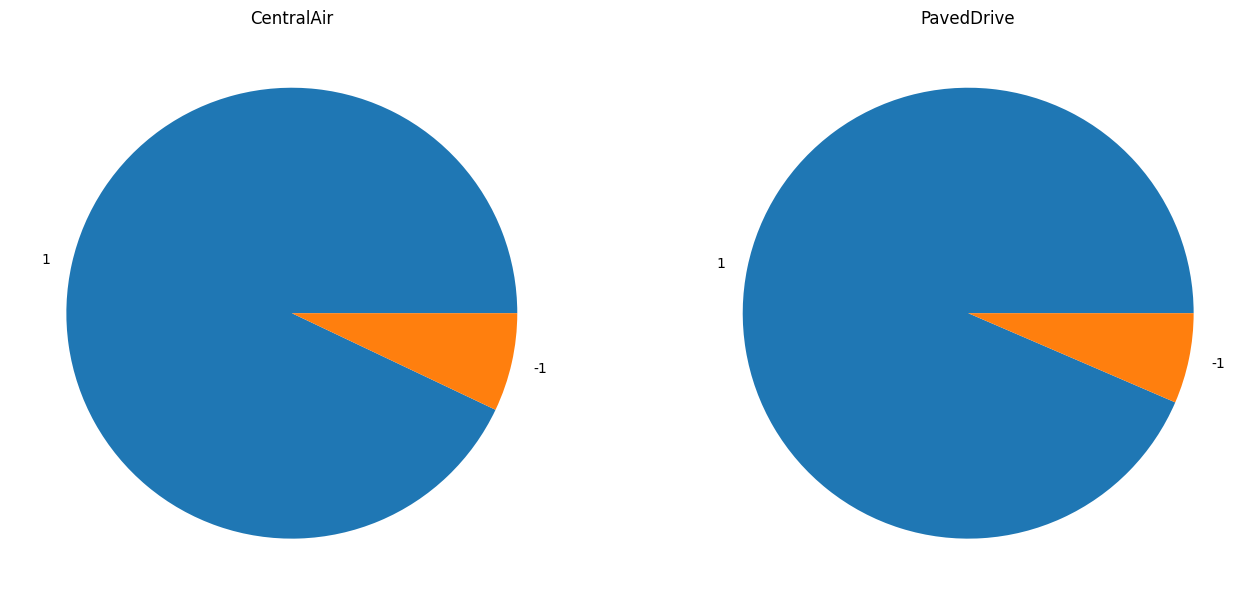

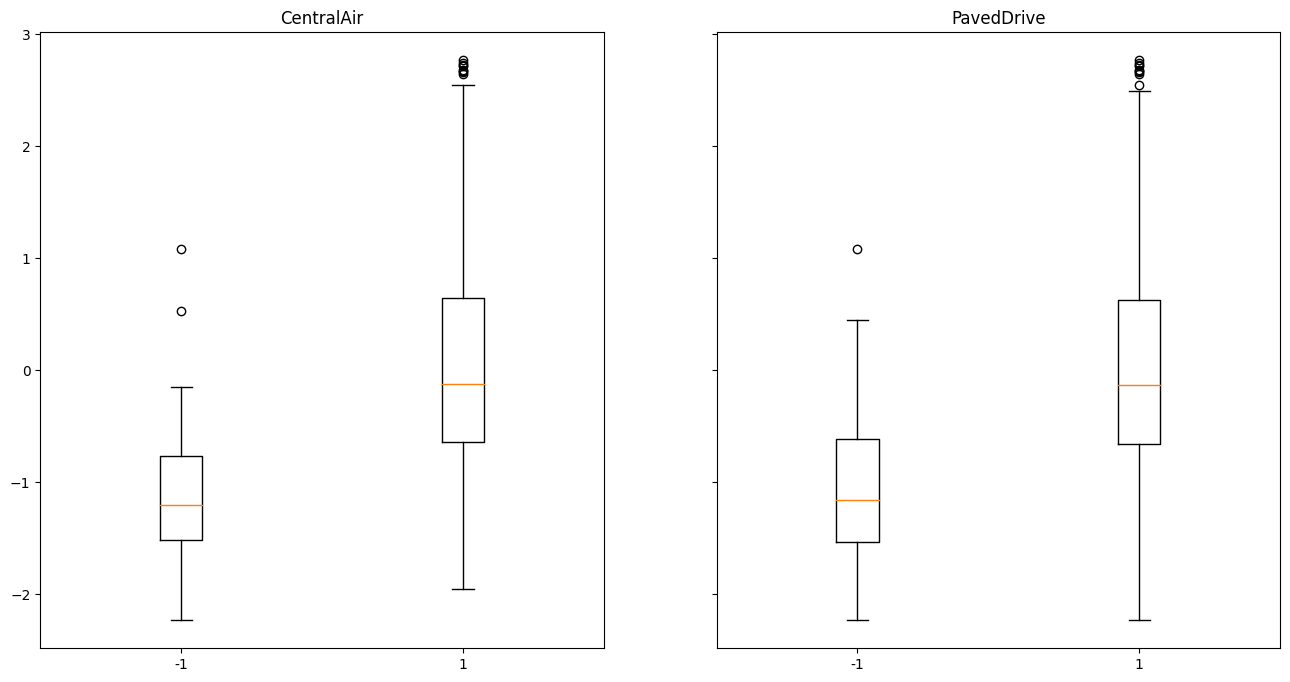

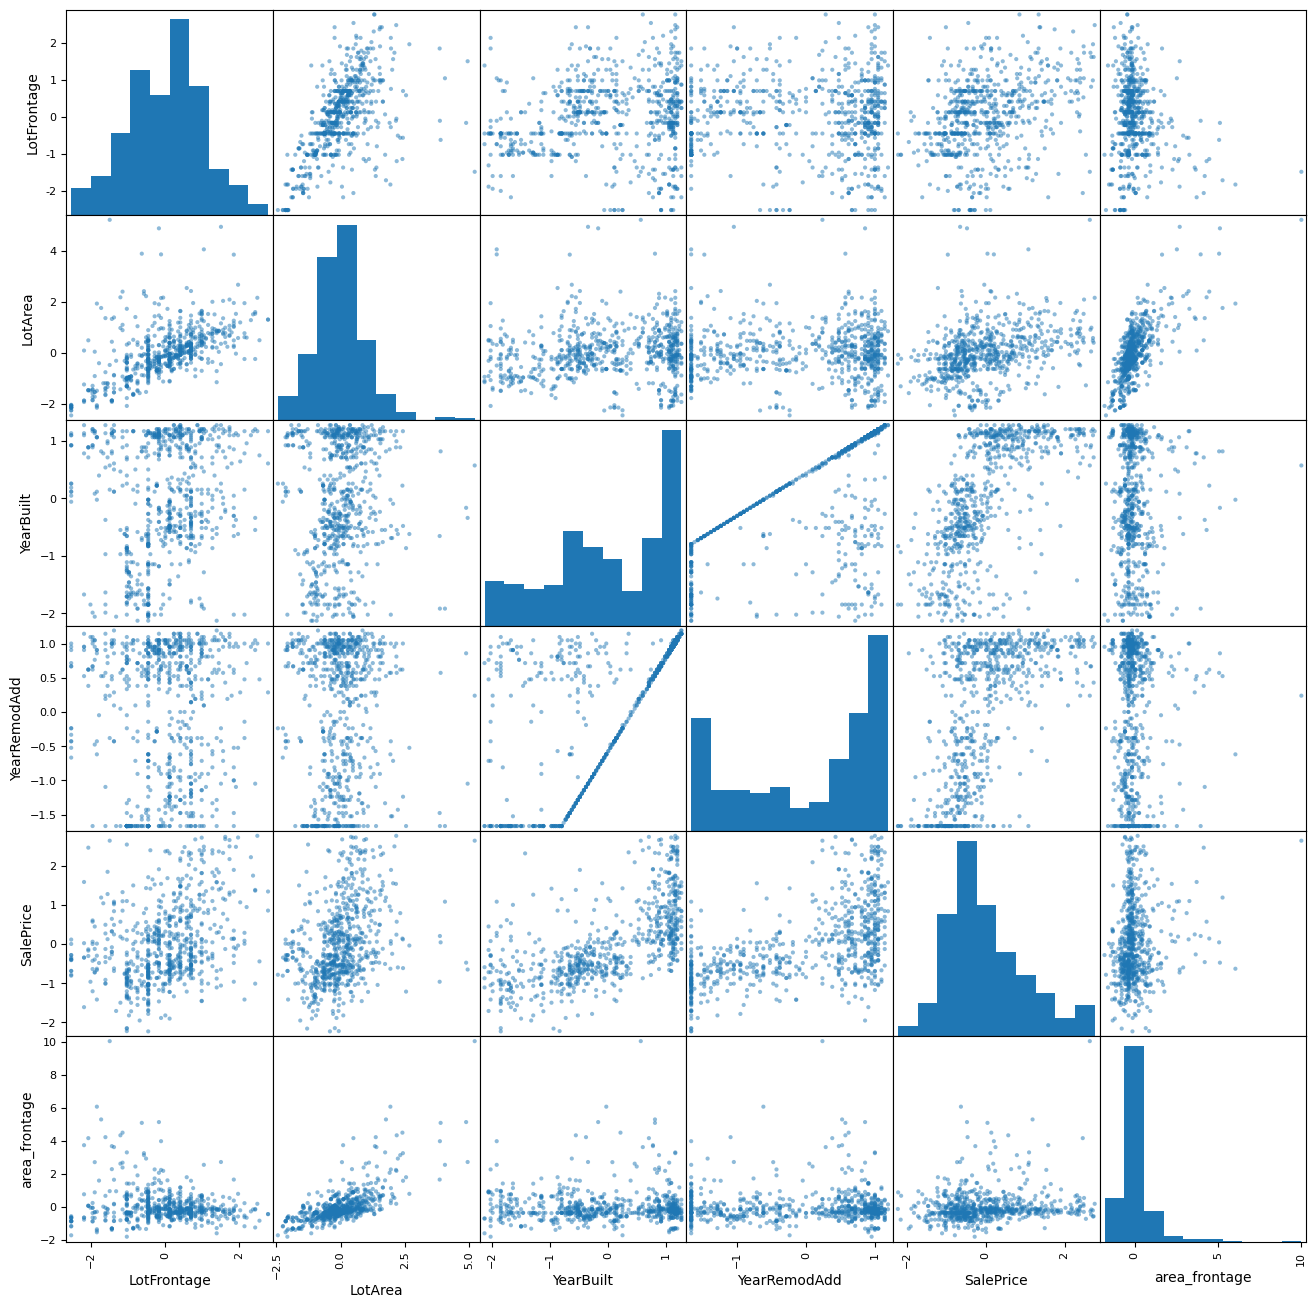

In [113]:
fig, axs = plt.subplots(1, len(numeric_cols_f), sharey=True, figsize=(16, 16 / len(numeric_cols_f)))
n_repo = pandas.DataFrame([numeric_report(df_f_s[numeric_cols_f[i]], axs[i]) for i in range(len(numeric_cols_f))])
n_repo = n_repo.set_index("name")
display(n_repo)
qqq = plt.plot()

fig, axs = plt.subplots(1, len(categorical_cols_f), sharey=True, figsize=(16, 16 / len(categorical_cols_f)))
c_repo = pandas.DataFrame([categorical_report(df_f_s[categorical_cols_f[i]], axs[i]) for i in range(len(categorical_cols_f))])
c_repo = c_repo.set_index("name")
display(c_repo)
qqq = plt.plot()

fig, axs = plt.subplots(1, len(categorical_cols_f), sharey=True, figsize=(16, 16 / len(categorical_cols_f)))
for i in range(len(categorical_cols_f)):
    set_box_plot(df_f_s[[categorical_cols_f[i], "SalePrice"]], axs[i])
qqq = plt.plot()

qqq = pandas.plotting.scatter_matrix(df_f_s[numeric_cols_f], figsize=[16, 16])

From the scatter matrix we can see clear corelation on majority of columns with SalePrice

----

### P2. Implementation of KNN, DT, and RF

* Requirements for algorithms (parameters to change)
    * KNN – k value
    * DT – minSamplesLeaf; maxDepth.
    * RF – nEstimators;
* Implementation can be based on lectures or online materials, but references to the original source (if used) are necessary. Student must be able to comment any line (even if it is used from examples or other materials).

----

In [128]:
class KNN:
    def __init__(self, features, label):
        self.features = features
        self.label = label
        self.len = features.shape[0]
    def __get_distance(self, features):
        res = (((self.features - features) ** 2).sum(axis = 1) ** 0.5).sort_values()
        return(res)
    def __predict_single(self, features, k):
        k = min([k, self.len])
        ids = self.__get_distance(features).iloc[0:k].index
        res = self.label.loc[ids].mean()
        return(res)
    def predict(self, features, k):
        if not isinstance(features, pandas.DataFrame): return(self.__predict_single(features, k))
        res = features.apply(lambda row: self.__predict_single(row, k), axis=1)
        return res

In [162]:
def split_data(df, p = 0.5):
    total = df.shape[0]
    split = int(total * p)
    train = df[:split]
    test = df[split:]
    return(train, test)

train, test = split_data(df_f_s)

In [163]:
def get_mse(df):
    res = ((df[df.columns[0]] - df[df.columns[1]]) ** 2).sum()
    res = res / df.shape[0]
    return(res)

In [164]:
knn_model = KNN(train.drop("SalePrice", axis=1), train["SalePrice"])
k = 3
train_res = train[["SalePrice"]].join(pandas.DataFrame(knn_model.predict(train, k), columns=["pred"]))


train_res

#tr#ain["SalePrice"]

#k = 3
#train_res = pandas.DataFrame(knn_model.predict(train, 3))
#train_res["real"] = train[["SalePrice"]]
#print(train_res)
#knn_model.predict(train, 3)

,SalePrice,pred
Id,,
1,0.587842,0.403790
2,0.149365,0.173725
3,0.831440,0.387550
4,-0.524590,-0.454217
5,1.261797,0.427608
...,...,...
493,0.007835,1.752934
494,-0.280992,-0.278285
495,-1.315472,-1.251211


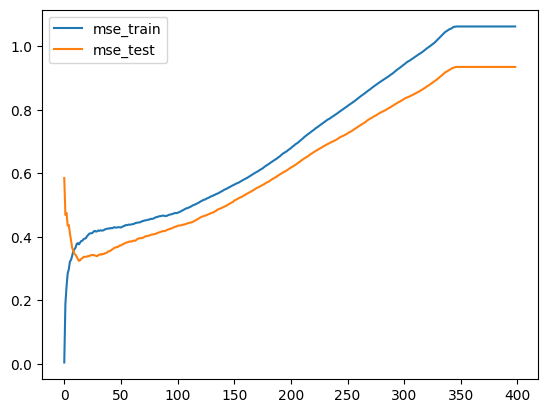

In [167]:
knn_model = KNN(train.drop("SalePrice", axis=1), train["SalePrice"])
mse_train = []
mse_test = []
for k in range(1, 400):
    train_res = train[["SalePrice"]].join(pandas.DataFrame(knn_model.predict(train, k), columns=["pred"]))
    mse_train.append(get_mse(train_res))
    test_res = test[["SalePrice"]].join(pandas.DataFrame(knn_model.predict(test, k), columns=["pred"]))
    mse_test.append(get_mse(test_res))
plt.plot(mse_train, label = "mse_train")
plt.plot(mse_test, label = "mse_test")
plt.legend()
plt.show()

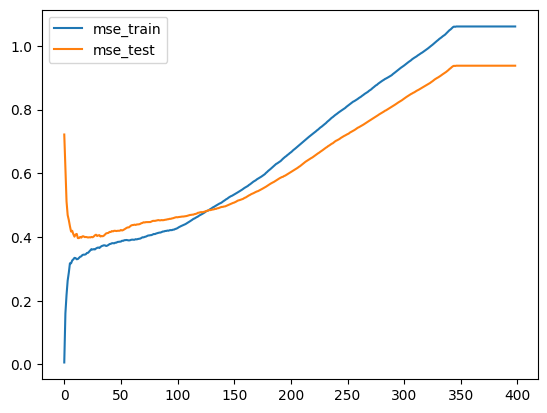

In [169]:
TMPPP = df_f_s.copy()

TMPPP = TMPPP.sample(frac=1).reset_index(drop=True)

train, test = split_data(TMPPP)

knn_model = KNN(train.drop("SalePrice", axis=1), train["SalePrice"])
mse_train = []
mse_test = []
for k in range(1, 400):
    train_res = train[["SalePrice"]].join(pandas.DataFrame(knn_model.predict(train, k), columns=["pred"]))
    mse_train.append(get_mse(train_res))
    test_res = test[["SalePrice"]].join(pandas.DataFrame(knn_model.predict(test, k), columns=["pred"]))
    mse_test.append(get_mse(test_res))
plt.plot(mse_train, label = "mse_train")
plt.plot(mse_test, label = "mse_test")
plt.legend()
plt.show()



In [ ]:
print(get_mse(train_res))